In [1]:
import pandas as pd
import os
import gc
import lightgbm as lgb
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.decomposition import TruncatedSVD, SparsePCA
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec
import math
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
preliminary_a_food = pd.read_csv('./初赛A榜测试集/preliminary_a_food.csv')
preliminary_a_submit_sample = pd.read_csv('./初赛A榜测试集/preliminary_a_submit_sample.csv')
train_food = pd.read_csv('./训练集/train_food.csv')
train_answer = pd.read_csv('./训练集/train_answer.csv')

disease_feature1 = pd.read_csv('./训练集/disease_feature1.csv')
disease_feature2 = pd.read_csv('./训练集/disease_feature2.csv')
disease_feature3 = pd.read_csv('./训练集/disease_feature3.csv')

In [3]:
del preliminary_a_submit_sample['related_prob']

In [4]:
data = pd.concat([train_answer, preliminary_a_submit_sample], axis = 0).reset_index(drop=True)
data.head()

,food_id,disease_id,related
0,food_0,disease_998,0.0
1,food_0,disease_861,0.0
2,food_0,disease_559,0.0
3,food_0,disease_841,0.0
4,food_0,disease_81,0.0


In [5]:
data['food'] = data['food_id'].apply(lambda x : int(x.split('_')[1]))
data['disease'] = data['disease_id'].apply(lambda x : int(x.split('_')[1]))

In [6]:
food = pd.concat([train_food, preliminary_a_food], axis = 0).reset_index(drop=True)
food.head()

,food_id,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,...,N_202,N_203,N_204,N_205,N_206,N_207,N_208,N_209,N_210,N_211
0,food_0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.02,0.0,NaN,NaN,30.5,92.82,NaN,0.92
1,food_1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,23.90,0.0,NaN,NaN,0.0,2.41,NaN,3.31
2,food_4,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.12,0.0,NaN,NaN,3.5,15.46,NaN,0.36
3,food_5,NaN,NaN,NaN,0.068,0.0,0.045,0.75,0.314,NaN,...,NaN,NaN,0.89,0.0,NaN,NaN,3.3,86.35,NaN,0.20
4,food_6,NaN,NaN,NaN,0.115,0.0,0.091,0.58,0.508,NaN,...,NaN,NaN,1.13,0.0,0.0,NaN,41.6,93.22,NaN,0.54


In [7]:
cat_list = ['disease']
def stat(df, df_merge, group_by, agg):
    group = df.groupby(group_by).agg(agg)

    columns = []
    for on, methods in agg.items():
        for method in methods:
            columns.append('{}_{}_{}'.format('_'.join(group_by), on, method))
    group.columns = columns
    group.reset_index(inplace=True)
    df_merge = df_merge.merge(group, on=group_by, how='left')

    del (group)
    gc.collect()
    return df_merge

def statis_feat(df_know, df_unknow,cat_list):
    for f in tqdm(cat_list):
        df_unknow = stat(df_know, df_unknow, [f], {'related': ['mean']})

    return df_unknow

df_train = data[~data['related'].isnull()]
df_train = df_train.reset_index(drop=True)
df_test = data[data['related'].isnull()]

df_stas_feat = None
kf = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
for train_index, val_index in kf.split(df_train, df_train['related']):
    df_fold_train = df_train.iloc[train_index]
    df_fold_val = df_train.iloc[val_index]

    df_fold_val = statis_feat(df_fold_train, df_fold_val,cat_list)
    df_stas_feat = pd.concat([df_stas_feat, df_fold_val], axis=0)

    del (df_fold_train)
    del (df_fold_val)
    gc.collect()

df_test = statis_feat(df_train, df_test,cat_list)
data = pd.concat([df_stas_feat, df_test], axis=0)
data = data.reset_index(drop=True)

del (df_stas_feat)
del (df_train)
del (df_test)

100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


### 食物特征

In [8]:
# 删除 NAN 较多的特征
(food.isnull().sum().sort_values()/food.shape[0]).describe()

count    213.000000
mean       0.676928
std        0.357525
min        0.000000
25%        0.330454
50%        0.898488
75%        0.993521
max        1.000000
dtype: float64

In [19]:
t = ((food.isnull().sum().sort_values()/food.shape[0])>=0.20)
t

food_id    False
N_188      False
N_209      False
N_74       False
N_14       False
           ...  
N_38        True
N_70        True
N_39        True
N_36        True
N_66        True
Length: 213, dtype: bool

In [21]:
select_food_feat = t[t==False].index.tolist()
len(select_food_feat)

36

In [ ]:
# food = food[select_food_feat]

### 疾病特征

In [22]:
# 查看重复特征
disease_feat1_cols = disease_feature1.columns.tolist()
disease_feat2_cols = disease_feature2.columns.tolist()
disease_feat3_cols = disease_feature3.columns.tolist()

set(disease_feat1_cols)&set(disease_feat2_cols)&set(disease_feat3_cols) # 100 多个

{'F_1114',
 'F_1190',
 'F_1227',
 'F_1257',
 'F_1260',
 'F_1278',
 'F_1352',
 'F_1368',
 'F_1382',
 'F_1389',
 'F_1395',
 'F_1419',
 'F_1443',
 'F_1460',
 'F_1513',
 'F_1520',
 'F_1594',
 'F_1610',
 'F_1620',
 'F_1628',
 'F_1630',
 'F_1684',
 'F_1709',
 'F_1712',
 'F_1721',
 'F_1776',
 'F_1780',
 'F_1782',
 'F_183',
 'F_1833',
 'F_1838',
 'F_184',
 'F_1849',
 'F_1857',
 'F_187',
 'F_192',
 'F_1981',
 'F_2007',
 'F_2032',
 'F_2058',
 'F_2068',
 'F_2091',
 'F_2094',
 'F_2103',
 'F_2106',
 'F_2118',
 'F_2183',
 'F_2190',
 'F_2196',
 'F_2207',
 'F_2345',
 'F_2398',
 'F_2416',
 'F_2419',
 'F_2428',
 'F_2430',
 'F_2433',
 'F_2504',
 'F_2535',
 'F_2554',
 'F_256',
 'F_265',
 'F_2673',
 'F_269',
 'F_281',
 'F_2843',
 'F_2849',
 'F_2891',
 'F_290',
 'F_2900',
 'F_291',
 'F_2921',
 'F_2982',
 'F_2984',
 'F_3002',
 'F_3034',
 'F_3057',
 'F_3154',
 'F_3159',
 'F_3190',
 'F_3228',
 'F_3272',
 'F_3328',
 'F_3364',
 'F_3398',
 'F_3401',
 'F_3406',
 'F_346',
 'F_3588',
 'F_3623',
 'F_3638',
 'F_3651',

In [23]:
def 降维(feat, ndim=128):
    decom=TruncatedSVD(n_components=ndim, n_iter = 20, random_state=222222)
    decom_x=decom.fit_transform(feat)
    
    return decom_x

In [24]:
# disease 降维
feat1 = 降维(disease_feature1.iloc[:,1:])
feat2 = 降维(disease_feature2.iloc[:,1:])
feat3 = 降维(disease_feature3.iloc[:,1:])

df_feat1 = pd.DataFrame(feat1)
df_feat2 = pd.DataFrame(feat2)
df_feat3 = pd.DataFrame(feat3)

df_feat1.columns = ['disease1_svd_'+str(i) for i in range(df_feat1.shape[1])]
df_feat2.columns = ['disease2_svd_'+str(i) for i in range(df_feat2.shape[1])]
df_feat3.columns = ['disease3_svd_'+str(i) for i in range(df_feat3.shape[1])]

disease_feature1 = disease_feature1[['disease_id']]
disease_feature2 = disease_feature2[['disease_id']]
disease_feature3 = disease_feature3[['disease_id']]

for col in df_feat1.columns:
    disease_feature1[col] = df_feat1[col]
    
for col in df_feat2.columns:
    disease_feature2[col] = df_feat2[col]
    
for col in df_feat3.columns:
    disease_feature3[col] = df_feat3[col]
    

In [25]:
data = data.merge(food[select_food_feat], on = 'food_id', how = 'left')
data = data.merge(disease_feature1, on = 'disease_id', how = 'left')
data = data.merge(disease_feature2, on = 'disease_id', how = 'left')
data = data.merge(disease_feature3, on = 'disease_id', how = 'left')
data.head()

,food_id,disease_id,related,food,disease,disease_related_mean,N_188,N_209,N_74,N_14,...,disease3_svd_118,disease3_svd_119,disease3_svd_120,disease3_svd_121,disease3_svd_122,disease3_svd_123,disease3_svd_124,disease3_svd_125,disease3_svd_126,disease3_svd_127
0,food_0,disease_861,0.0,0,861,0.003521,0.69,92.82,0.96,32.0,...,0.003703,-0.050574,-0.049544,-0.017477,-0.116327,0.084615,0.072785,0.119895,0.032582,-0.025831
1,food_0,disease_839,0.0,0,839,0.007299,0.69,92.82,0.96,32.0,...,-0.004123,0.011799,-0.012938,-0.005243,0.024514,-0.021790,-0.020413,0.080022,0.056968,-0.013960
2,food_0,disease_50,0.0,0,50,0.018382,0.69,92.82,0.96,32.0,...,0.082681,-0.008134,-0.059040,0.072839,-0.040822,0.002879,-0.031253,0.013910,-0.015712,0.062177
3,food_0,disease_1370,0.0,0,1370,0.214286,0.69,92.82,0.96,32.0,...,-0.113983,0.041052,-0.060705,0.031433,0.020547,0.045441,0.060714,-0.054746,-0.081826,-0.040950
4,food_0,disease_1015,0.0,0,1015,0.202749,0.69,92.82,0.96,32.0,...,-0.035114,-0.033595,-0.015735,-0.043079,0.034971,0.070341,-0.097128,0.082166,-0.014477,0.011394


### 特征交叉

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
# 多项式交叉
poly = PolynomialFeatures(degree=2,interaction_only=True)

In [28]:
t = ((food.isnull().sum().sort_values()/food.shape[0])>=0.20)
poly_cols = t[t==False].index.tolist()

In [59]:
len(poly_cols)

36

In [29]:
poly_feats = poly.fit_transform(food[poly_cols].fillna(0).iloc[:,1:])
df_poly_feats = pd.DataFrame(poly_feats)
df_poly_feats.columns = [f"food_poly_{i}" for i in range(poly_feats.shape[1])]
df_poly_feats['food_id'] = food.food_id
df_poly_feats

,food_poly_0,food_poly_1,food_poly_2,food_poly_3,food_poly_4,food_poly_5,food_poly_6,food_poly_7,food_poly_8,food_poly_9,...,food_poly_622,food_poly_623,food_poly_624,food_poly_625,food_poly_626,food_poly_627,food_poly_628,food_poly_629,food_poly_630,food_id
0,1.0,0.69,92.82,0.96,32.0,3.99,2.10,70.0,0.126,23.0,...,0.003304,0.003136,0.000448,0.013806,0.013104,0.001872,0.003304,0.000472,0.000448,food_0
1,1.0,52.54,2.41,3.73,268.0,20.96,21.01,471.0,1.197,598.0,...,110.738448,1083.371304,23.285504,43.339860,424.000530,9.113280,109.660392,2.356992,23.058816,food_1
2,1.0,0.25,15.46,1.79,62.0,3.30,79.32,98.0,0.125,299.0,...,0.001344,0.000552,0.000312,0.002184,0.000897,0.000507,0.001288,0.000728,0.000299,food_4
3,1.0,0.39,86.35,0.39,13.0,1.40,11.12,23.0,0.040,124.5,...,0.004080,0.028900,0.000510,0.001848,0.013090,0.000231,0.004080,0.000072,0.000510,food_5
4,1.0,0.12,93.22,2.14,24.0,2.20,3.88,52.0,0.141,52.5,...,0.000000,0.000000,0.000000,0.001600,0.000000,0.000000,0.000000,0.000000,0.000000,food_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,1.0,0.31,85.17,0.15,37.0,0.81,13.34,20.0,0.036,53.0,...,0.002100,0.003180,0.000120,0.001680,0.002544,0.000096,0.001855,0.000070,0.000106,food_570
459,1.0,0.28,92.07,0.42,22.0,1.92,4.97,44.0,0.060,64.5,...,0.003162,0.000918,0.000306,0.001488,0.000432,0.000144,0.002511,0.000837,0.000243,food_572
460,1.0,0.10,92.18,0.47,40.0,1.28,5.80,26.0,0.040,64.0,...,0.000578,0.000289,0.000000,0.000578,0.000289,0.000000,0.000578,0.000000,0.000000,food_578
461,1.0,0.07,61.10,0.75,2.0,1.25,36.66,31.0,0.100,393.5,...,0.001102,0.000304,0.000741,0.001450,0.000400,0.000975,0.000928,0.002262,0.000624,food_584


In [30]:
# 暴力特征交叉
topn = ['N_33', 'N_198', 'N_74','disease','food']
for i in range(len(topn)):
    for j in range(i + 1, len(topn)):
        data[f'{topn[i]}+{topn[j]}'] = data[topn[i]] + data[topn[j]]
        data[f'{topn[i]}-{topn[j]}'] = data[topn[i]] - data[topn[j]]
        data[f'{topn[i]}*{topn[j]}'] = data[topn[i]] * data[topn[j]]
        data[f'{topn[i]}/{topn[j]}'] = data[topn[i]] / (data[topn[j]]+1e-5)

In [31]:
data = data.merge(df_poly_feats, on = 'food_id', how = 'left')
data

,food_id,disease_id,related,food,disease,disease_related_mean,N_188,N_209,N_74,N_14,...,food_poly_621,food_poly_622,food_poly_623,food_poly_624,food_poly_625,food_poly_626,food_poly_627,food_poly_628,food_poly_629,food_poly_630
0,food_0,disease_861,0.0,0,861,0.003521,0.69,92.82,0.96,32.0,...,0.013104,0.003304,0.003136,0.000448,0.013806,0.013104,0.001872,0.003304,0.000472,0.000448
1,food_0,disease_839,0.0,0,839,0.007299,0.69,92.82,0.96,32.0,...,0.013104,0.003304,0.003136,0.000448,0.013806,0.013104,0.001872,0.003304,0.000472,0.000448
2,food_0,disease_50,0.0,0,50,0.018382,0.69,92.82,0.96,32.0,...,0.013104,0.003304,0.003136,0.000448,0.013806,0.013104,0.001872,0.003304,0.000472,0.000448
3,food_0,disease_1370,0.0,0,1370,0.214286,0.69,92.82,0.96,32.0,...,0.013104,0.003304,0.003136,0.000448,0.013806,0.013104,0.001872,0.003304,0.000472,0.000448
4,food_0,disease_1015,0.0,0,1015,0.202749,0.69,92.82,0.96,32.0,...,0.013104,0.003304,0.003136,0.000448,0.013806,0.013104,0.001872,0.003304,0.000472,0.000448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188436,food_99,disease_81,NaN,99,81,0.382184,1.64,65.88,1.60,42.0,...,0.010855,0.004277,0.000169,0.000325,0.274715,0.010855,0.020875,0.004277,0.008225,0.000325
188437,food_99,disease_841,NaN,99,841,0.011494,1.64,65.88,1.60,42.0,...,0.010855,0.004277,0.000169,0.000325,0.274715,0.010855,0.020875,0.004277,0.008225,0.000325
188438,food_99,disease_559,NaN,99,559,0.017241,1.64,65.88,1.60,42.0,...,0.010855,0.004277,0.000169,0.000325,0.274715,0.010855,0.020875,0.004277,0.008225,0.000325
188439,food_99,disease_290,NaN,99,290,0.112069,1.64,65.88,1.60,42.0,...,0.010855,0.004277,0.000169,0.000325,0.274715,0.010855,0.020875,0.004277,0.008225,0.000325


In [32]:
drop_cols = ['disease_id', 'food_id', 'related']
for f in data.columns:
    if data[f].nunique() < 2:
        drop_cols.append(f)
        
test_df = data[data["related"].isnull() == True].copy().reset_index(drop=True)
train_df = data[~data["related"].isnull() == True].copy().reset_index(drop=True)

In [33]:
feature_name = [f for f in train_df.columns if f not in drop_cols]
X_train = train_df[feature_name].reset_index(drop=True)
X_test = test_df[feature_name].reset_index(drop=True)
y = train_df['related'].reset_index(drop=True)
print(len(feature_name))
print(feature_name)

1092
['food', 'disease', 'disease_related_mean', 'N_188', 'N_209', 'N_74', 'N_14', 'N_113', 'N_17', 'N_106', 'N_146', 'N_42', 'N_177', 'N_101', 'N_165', 'N_111', 'N_82', 'N_211', 'N_33', 'N_198', 'N_197', 'N_61', 'N_22', 'N_194', 'N_145', 'N_195', 'N_57', 'N_60', 'N_147', 'N_59', 'N_62', 'N_50', 'N_49', 'N_48', 'N_114', 'N_155', 'N_94', 'N_157', 'disease1_svd_0', 'disease1_svd_1', 'disease1_svd_2', 'disease1_svd_3', 'disease1_svd_4', 'disease1_svd_5', 'disease1_svd_6', 'disease1_svd_7', 'disease1_svd_8', 'disease1_svd_9', 'disease1_svd_10', 'disease1_svd_11', 'disease1_svd_12', 'disease1_svd_13', 'disease1_svd_14', 'disease1_svd_15', 'disease1_svd_16', 'disease1_svd_17', 'disease1_svd_18', 'disease1_svd_19', 'disease1_svd_20', 'disease1_svd_21', 'disease1_svd_22', 'disease1_svd_23', 'disease1_svd_24', 'disease1_svd_25', 'disease1_svd_26', 'disease1_svd_27', 'disease1_svd_28', 'disease1_svd_29', 'disease1_svd_30', 'disease1_svd_31', 'disease1_svd_32', 'disease1_svd_33', 'disease1_svd_34

In [40]:
print(test_df.shape)

(46805, 1096)


In [35]:
train_pred = {}
test_pred = {}

In [36]:
seeds = [222222]
num_model_seed = 1
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
parameters = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 63,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 222222,
    'bagging_seed': 1,
    'feature_fraction_seed': 7,
    'min_data_in_leaf': 20,
    'verbose': -1, 
    'n_jobs':8
}
fold = 5
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(test_x, label=test_y)
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dval],
            early_stopping_rounds=100,
            verbose_eval=100, )
        oof_cat[test_index] += lgb_model.predict(test_x,num_iteration=lgb_model.best_iteration)
        prediction_cat += lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration) / fold
        feat_imp_df['imp'] += lgb_model.feature_importance()

        del train_x
        del test_x
        del train_y
        del test_y
        del lgb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
gc.collect()

222222 --------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.951259
[200]	valid_0's auc: 0.962142
[300]	valid_0's auc: 0.967076
[400]	valid_0's auc: 0.970047
[500]	valid_0's auc: 0.971846
[600]	valid_0's auc: 0.973256
[700]	valid_0's auc: 0.974325
[800]	valid_0's auc: 0.975085
[900]	valid_0's auc: 0.975655
[1000]	valid_0's auc: 0.976334
[1100]	valid_0's auc: 0.976831
[1200]	valid_0's auc: 0.97722
[1300]	valid_0's auc: 0.97771
[1400]	valid_0's auc: 0.977963
[1500]	valid_0's auc: 0.978233
[1600]	valid_0's auc: 0.978487
[1700]	valid_0's auc: 0.978738
[1800]	valid_0's auc: 0.978938
[1900]	valid_0's auc: 0.979186
[2000]	valid_0's auc: 0.979368
[2100]	valid_0's auc: 0.979511
[2200]	valid_0's auc: 0.97962
[2300]	valid_0's auc: 0.979699
[2400]	valid_0's auc: 0.979803
[2500]	valid_0's auc: 0.979969
[2600]	valid_0's auc: 0.980052
[2700]	valid_0's auc: 0.980149
[2800]	valid_

722

In [37]:
train_pred['lgb'] = oof
test_pred['lgb'] = prediction
print("lgb train auc: ", roc_auc_score(y, train_pred['lgb']))

lgb train auc:  0.9804256602884427


In [47]:
# xgb
import xgboost as xgb

seeds = [2222222]
num_model_seed = 1
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
parameters = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': ['logloss','auc'],
    'gamma': 0.1,
    'max_depth': 6, # 树的最大深度
    'alpha': 0, # 关于权重的L1正则化项
    'lambda': 0,
    'subsample': 0.7,
    'colsample_bytree': 0.5,
    'min_child_weight': 3,
    'silent': 0,
    'eta': 0.03, # 学习率
    'nthread': -1,
    'seed': 2222222,
}
fold = 5
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        xgb_trn_data = xgb.DMatrix(train_x, label=train_y)
        xgb_val_data = xgb.DMatrix(test_x, label=test_y)
        watchlist = [(xgb_trn_data, 'train'), (xgb_val_data, 'valid')]
        clf_xgb = xgb.train(parameters, xgb_trn_data, 10000, watchlist, verbose_eval=100, early_stopping_rounds=500)
        
        oof_cat[test_index] += clf_xgb.predict(xgb.DMatrix(test_x))
        prediction_cat += clf_xgb.predict(xgb.DMatrix(X_test)) / fold
        # feat_imp_df['imp'] += list(clf_xgb.get_fscore().values())
        del train_x
        del test_x
        del train_y
        del test_y
        del clf_xgb
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
gc.collect()

2222222 --------------------------------------------------------------------------------------------
[23:39:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.67214	train-auc:0.76807	valid-logloss:0.67218	valid-auc:0.76316
[100]	train-logloss:0.17050	train-auc:0.95935	valid-logloss:0.17656	valid-auc:0.95236
[200]	train-logloss:0.13202	train-auc:0.97215	valid-logloss:0.14387	valid-auc:0.96218
[300]	train-logloss:0.11839	train-auc:0.97741	valid-logloss:0.13450	valid-auc:0.96549
[400]	train-logloss:0.10851	train-auc:0.98185	valid-logloss:0.12918	valid-auc:0.96802
[500]	train-logloss:0.10022	train-auc:0.98533	valid-logl

62

In [46]:
len(clf_xgb.get_fscore().values())

1086

In [48]:
train_pred['xgb'] = oof
test_pred['xgb'] = prediction

In [49]:
print("lgb train auc: ", roc_auc_score(y, train_pred['xgb']))

lgb train auc:  0.9763206490190071


In [50]:
train_pred['xgb_lgb'] = (0.7*train_pred['lgb'] + 0.3*train_pred['xgb'])
test_pred['xgb_lgb'] = (0.7*test_pred['lgb'] + 0.3*test_pred['xgb'])
print("lgb train auc: ", roc_auc_score(y, train_pred['xgb_lgb']))

lgb train auc:  0.9803465733467616


In [51]:
# LR 融合
from sklearn.linear_model import LinearRegression

lrg = LinearRegression()
train_prob = pd.DataFrame()
train_prob['lgb'] = train_pred['lgb']
train_prob['xgb'] = train_pred['xgb']
train_prob['label'] = y

test_prob = pd.DataFrame()
test_prob['lgb'] = test_pred['lgb']
test_prob['xgb'] = test_pred['xgb']
lrg.fit(train_prob[['lgb','xgb']], train_prob.label)
prob_y = lrg.predict(test_prob)

In [52]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.1,0.9,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (train_pred['xgb_lgb'].reshape((-1)) > threshold).astype('int')
    m = f1_score(y.values.reshape((-1)), preds, average='binary')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 

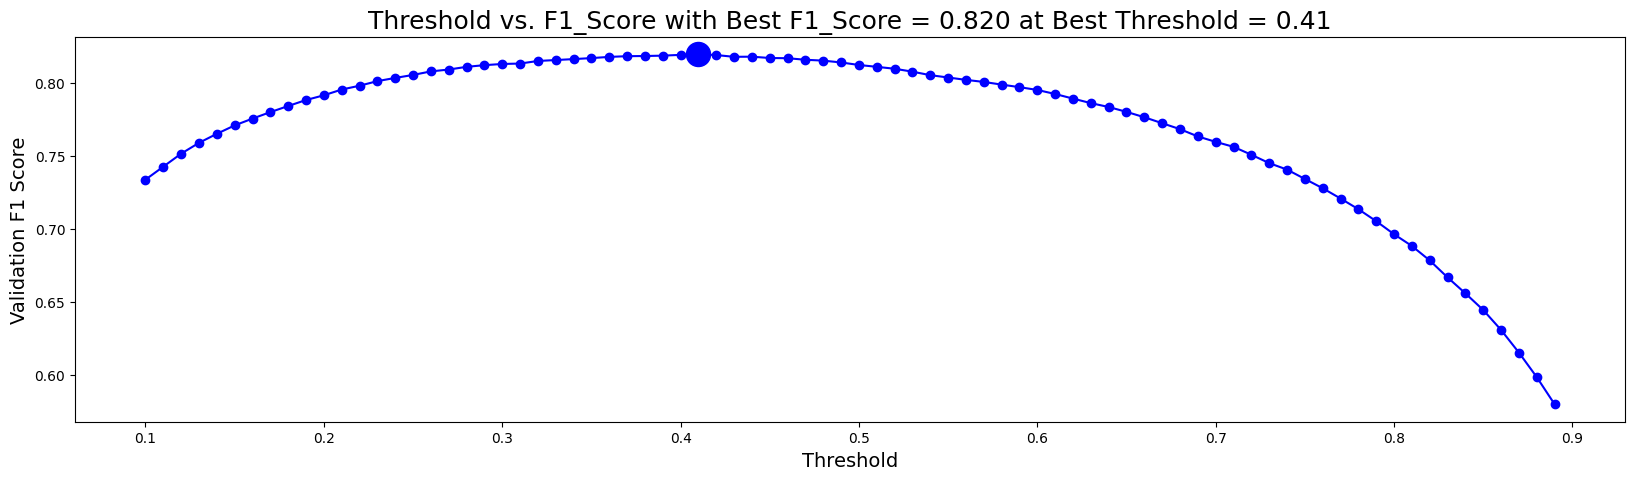

In [53]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [54]:
auc = roc_auc_score(y, train_pred['xgb_lgb'])
f1 = best_score
print((auc + f1) / 2)

0.8999581969597956


In [55]:
prediction = prob_y

In [56]:
label=[1 if x >= 0.262+0.238 else 0 for x in prediction+0.238]
np.sum(label)

4278

In [57]:
preliminary_a_submit_sample['related_prob'] = prediction+0.238

In [58]:
preliminary_a_submit_sample.to_csv('submit_0320_lr.csv', index=False)

In [ ]:
# food 缺失值比例小于 0.1 多项式交叉特征 ---> 阈值0.24 ---> 0.799236483193007